### Bio: Jane, Data Scientist
### Location: Bellevue, WA

### Scenario:  

Jane, is a data scientist at Figma Insurance who is working on training a binary classifier model that can predict fraudulent activity on insurance claims. Jane first uses SageMaker Studio with some python libraries to explore a dataset and finds some key characteristics that she can then use to engineer some features. Once she completes that, she decides to use XGboost framework to start training a base line model. This is exactly what you will start actioning on in this tutorial. You will use XGBoost and Pandas Libraries to start training a base line model and do some experimentation and model tuning with various parameters using SM Hyperparameter optimization. 

After Jane completes hyperparameter tuning, she is ready to deploy the model on a staging environment using SM Endpoints. Then she finishes up by conducting some inference test calls to understand how the model performs on a new unseen dataset. Once that is complete, she terminates her endpoints.

Six months later her new teammate, Beije, sees a deprecation in the performance of the deployed model which leads her to believe that the model might need to go through a re-training process. Thanks to SM pipeline, Beije can easily retrain the whole model using a new data with just a click of a button. 


# Step 1: Exploratory Data Analysis

In [5]:
import seaborn as sns  # visualisation
import matplotlib.pyplot as plt  # visualisation
import pandas as pd
%matplotlib inline
sns.set(color_codes=True)

read_bucket = "sagemaker-sample-files"
read_prefix = "datasets/tabular/synthetic_automobile_claims" 
train_data_key = f"{read_prefix}/train.csv"

train_data_uri = f"s3://{read_bucket}/{train_data_key}"
df_train_data = pd.read_csv(train_data_uri,  index_col=0)

In [6]:
print(df_train_data.isnull().sum().sum())

0


In [7]:
df_train_data.head(10)

,num_vehicles_involved,num_injuries,num_witnesses,police_report_available,injury_claim,vehicle_claim,total_claim_amount,incident_month,incident_day,incident_dow,...,authorities_contacted_ambulance,policy_state_ca,policy_state_az,policy_state_nv,policy_state_id,policy_state_wa,policy_state_or,customer_gender_other,customer_gender_male,customer_gender_female
fraud,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,71600,8913.668763,80513.668763,3,17,6,...,0,0,0,0,0,1,0,0,0,0
0,3,4,0,1,6400,19746.724395,26146.724395,12,11,2,...,0,1,0,0,0,0,0,0,1,0
0,2,1,0,0,3400,27987.704652,31387.704652,5,8,2,...,0,1,0,0,0,0,0,0,0,1
0,3,1,2,1,18100,35945.149280,54045.149280,5,20,0,...,0,1,0,0,0,0,0,0,0,0
0,1,0,0,0,16100,8307.428880,24407.428880,5,1,2,...,0,1,0,0,0,0,0,0,1,0
0,1,0,0,0,26600,7073.495700,33673.495700,2,13,2,...,0,0,0,0,0,1,0,0,0,1
0,2,0,1,0,2500,10692.498944,13192.498944,10,21,0,...,0,0,0,0,0,1,0,0,0,1
0,2,0,0,0,22000,12323.731644,34323.731644,6,27,3,...,0,1,0,0,0,0,0,0,1,0
0,1,0,0,0,5300,10317.520916,15617.520916,1,16,2,...,0,1,0,0,0,0,0,0,0,1


In [8]:
df_train_data.columns

Index(['num_vehicles_involved', 'num_injuries', 'num_witnesses',
       'police_report_available', 'injury_claim', 'vehicle_claim',
       'total_claim_amount', 'incident_month', 'incident_day', 'incident_dow',
       'incident_hour', 'customer_age', 'months_as_customer',
       'num_claims_past_year', 'num_insurers_past_5_years',
       'policy_deductable', 'policy_annual_premium', 'policy_liability',
       'customer_education', 'auto_year', 'driver_relationship_other',
       'driver_relationship_child', 'driver_relationship_spouse',
       'driver_relationship_na', 'driver_relationship_self',
       'incident_type_collision', 'incident_type_break-in',
       'incident_type_theft', 'collision_type_rear', 'collision_type_side',
       'collision_type_na', 'collision_type_front',
       'incident_severity_totaled', 'incident_severity_major',
       'incident_severity_minor', 'authorities_contacted_fire',
       'authorities_contacted_none', 'authorities_contacted_police',
       'auth

Text(0.5, 1.0, 'The dataset is heavily weighted towards male customers.')

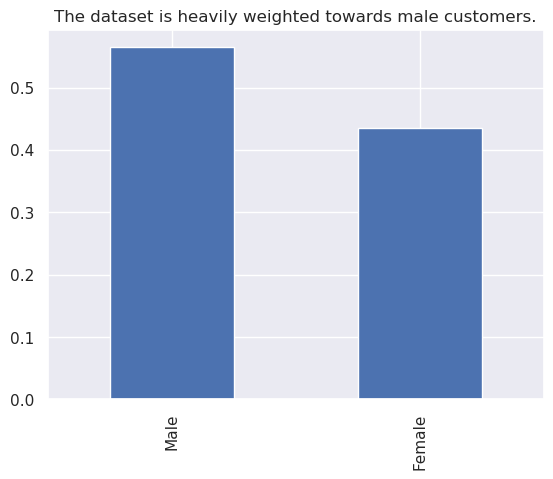

In [9]:
df_train_data.customer_gender_female.value_counts(normalize=True).plot.bar()
plt.xticks([0, 1], ["Male", "Female"]);
plt.title("The dataset is heavily weighted towards male customers.")

Text(0.5, 1.0, 'The overwhemling majority of claims are legitimate (i.e. not fraudulent).')

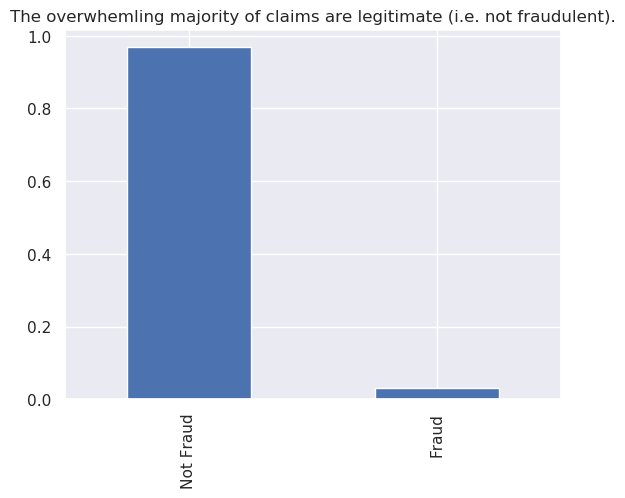

In [10]:
df_train_data = df_train_data.reset_index()
df_train_data.fraud.value_counts(normalize=True).plot.bar()
plt.xticks([0, 1], ["Not Fraud", "Fraud"]);
plt.title("The overwhemling majority of claims are legitimate (i.e. not fraudulent).")

Text(0.5, 1.0, 'Majority of the total claim amounts are under $25,000.')

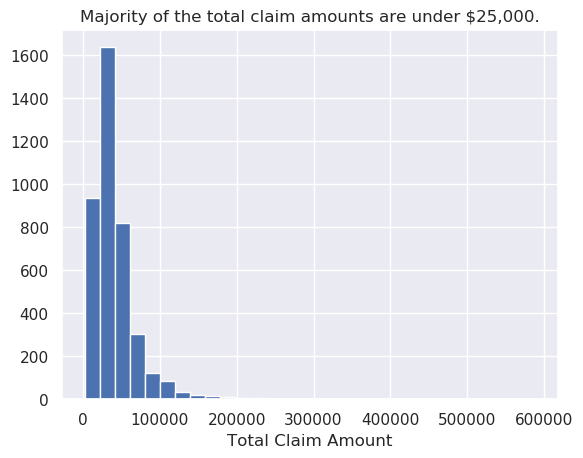

In [12]:
# plot the total claim amounts
plt.hist(df_train_data.total_claim_amount, bins=30)
plt.xlabel("Total Claim Amount")
plt.title("Majority of the total claim amounts are under $25,000.")

Text(0.5, 0, 'Number of claims per year')

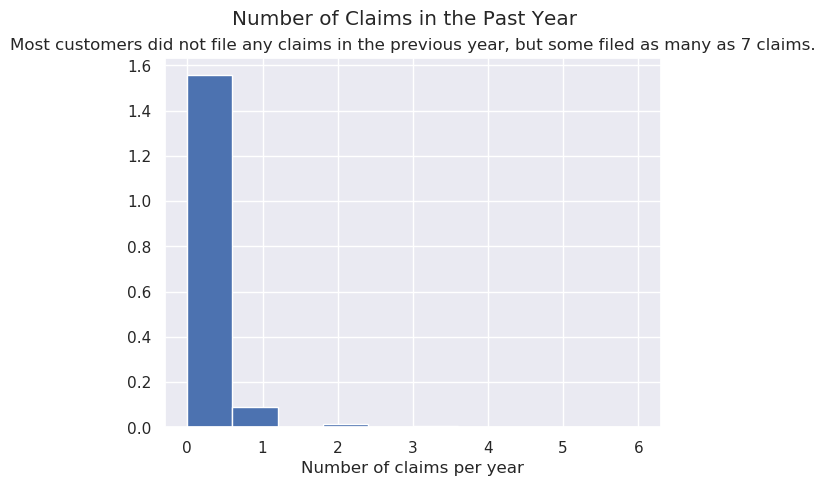

In [13]:
# plot the number of claims filed in the past year
df_train_data.num_claims_past_year.hist(density=True)
plt.suptitle("Number of Claims in the Past Year")
plt.title("Most customers did not file any claims in the previous year, but some filed as many as 7 claims.")
plt.xlabel("Number of claims per year")


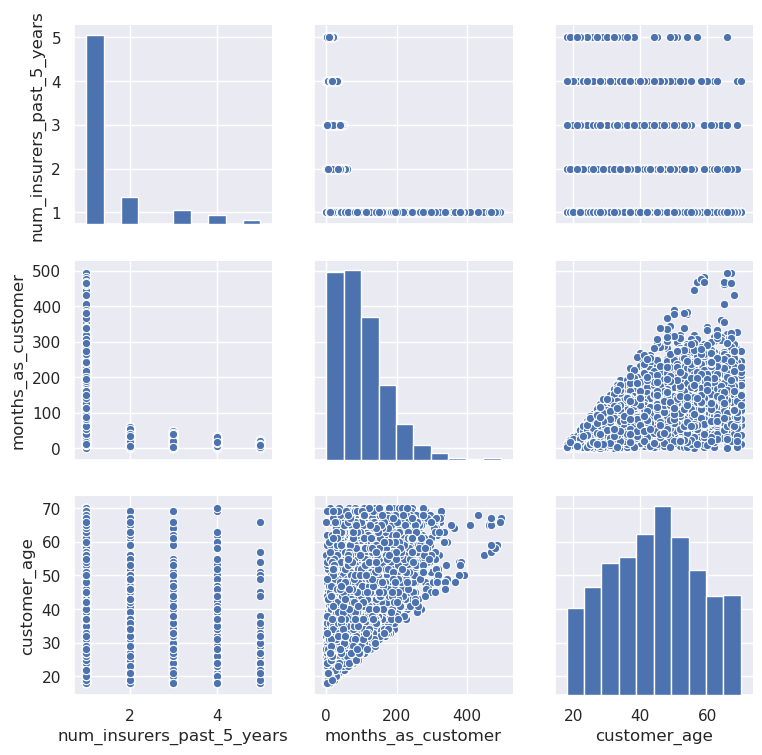

In [14]:
sns.pairplot(
    data=df_train_data, vars=["num_insurers_past_5_years", "months_as_customer", "customer_age"]
);

###  Understandably, the months_as_customer and customer_age are correlated with each other. A younger person have been driving for a smaller amount of time and therefore have a smaller potential for how long they might have been a customer.

### We can also see that the num_insurers_past_5_years is negatively correlated with months_as_customer. If someone frequently jumped around to different insurers, then they probably spent less time as a customer of this insurer.

Fraud is positively correlated with having a greater number of insurers over the past 5 years. Customers who switched insurers more frequently also had more prevelance of fraud.


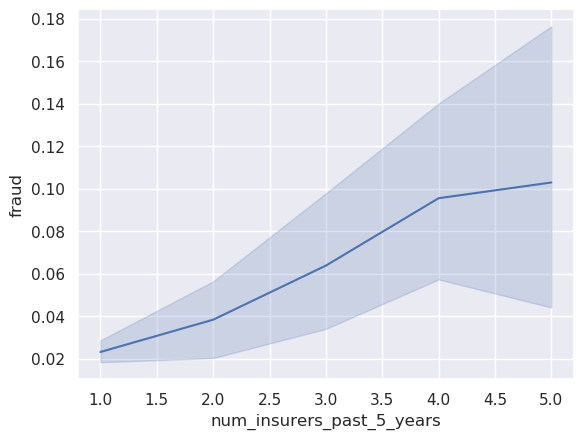

In [15]:

sns.lineplot(x="num_insurers_past_5_years", y="fraud", data=df_train_data);

print("Fraud is positively correlated with having a greater number of insurers over the past 5 years. Customers who switched insurers more frequently also had more prevelance of fraud.")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


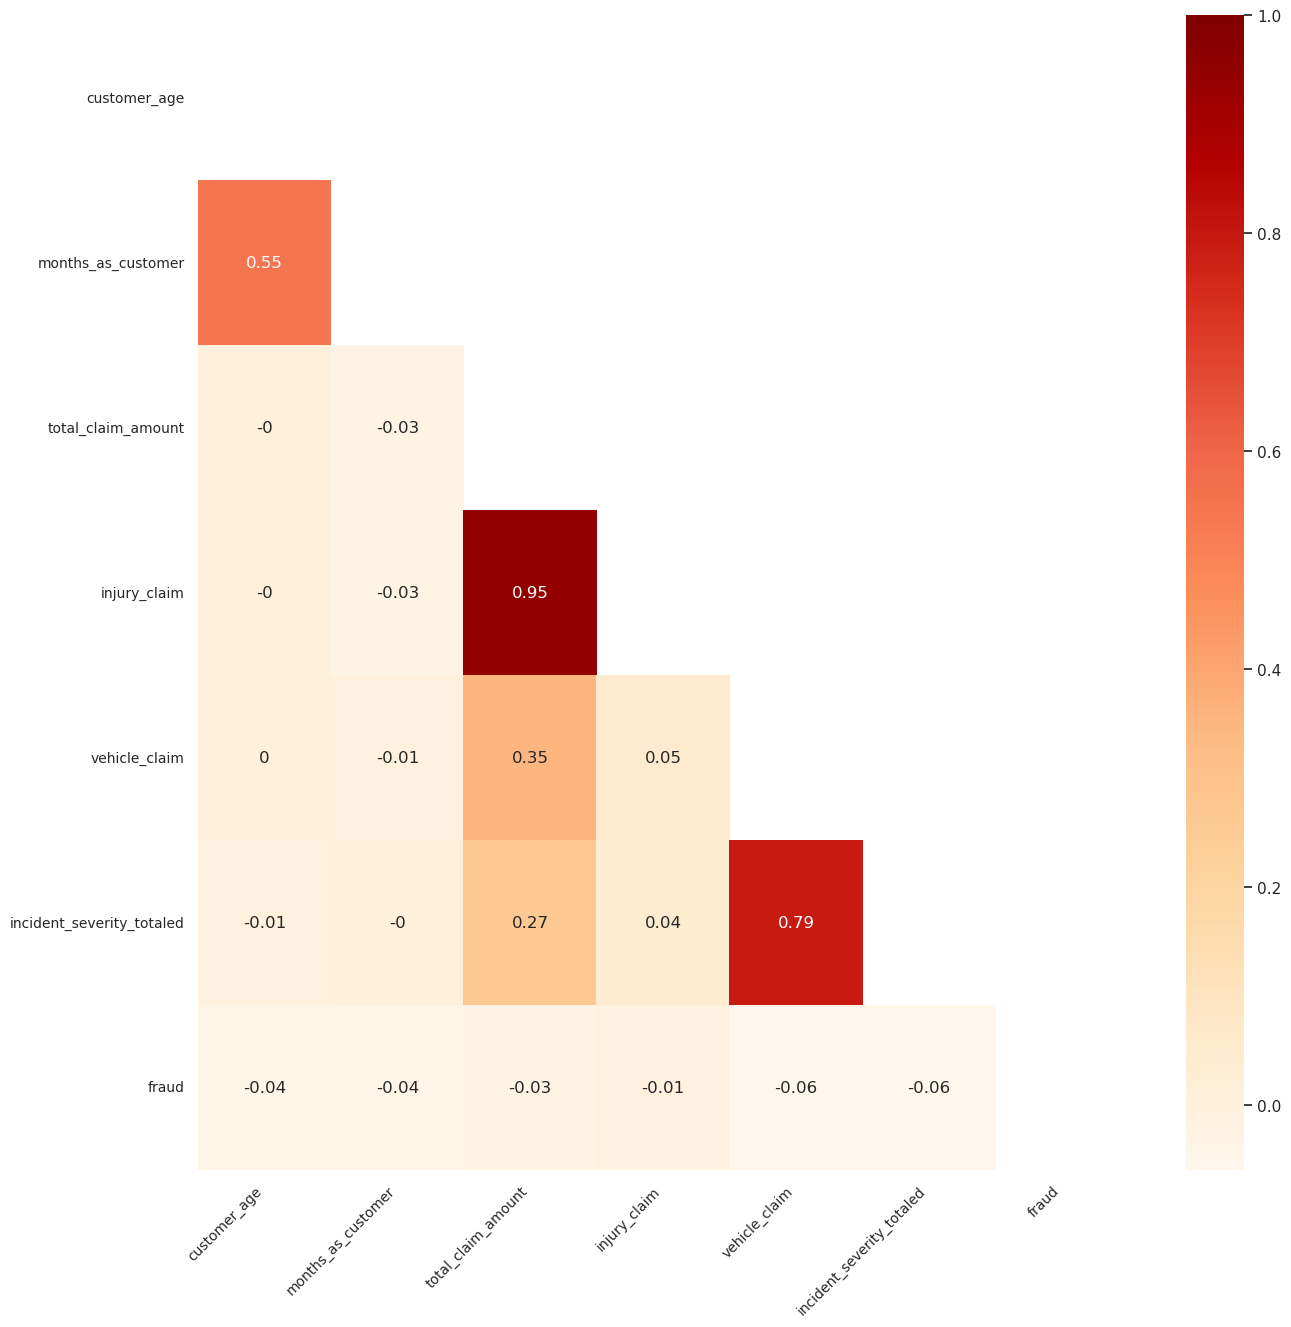

In [16]:
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("white")

corr_list = [
    "customer_age",
    "months_as_customer",
    "total_claim_amount",
    "injury_claim",
    "vehicle_claim",
    "incident_severity_totaled",
    "fraud",
]

corr_df = df_train_data[corr_list]
corr = round(corr_df.corr(), 2)

fix, ax = plt.subplots(figsize=(15, 15))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap="OrRd")

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha="right", rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

plt.show()

# Step 2: Set up a SageMaker Studio notebook ( library installation & variable settings)

In [58]:
%pip install -q  xgboost==1.3.1 pandas==1.0.5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.
sagemaker 2.143.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.1.0 which is incompatible.
sagemaker 2.143.0 requires PyYAML==5.4.1, but you have pyyaml 6.0 which is incompatible.
sagemaker-data-insights 0.3.3 requires pandas>=1.1.4, but you have pandas 1.0.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install boto3

Note: you may need to restart the kernel to use updated packages.


### NOTE: Please change your alias here as this will help us not intermix multiple users logs.

In [4]:
alias ='dewanup'

In [6]:
import pandas as pd
import boto3
import sagemaker
import json
import joblib
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner
)
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

# Setting SageMaker variables
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "fraud-detect-demo-"+alias

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)

sagemaker_role = sagemaker.get_execution_role()
sagemaker_client = boto3.client("sagemaker")
read_bucket = "sagemaker-sample-files"
read_prefix = "datasets/tabular/synthetic_automobile_claims" 


# Setting S3 location for read and write operations
train_data_key = f"{read_prefix}/train.csv"
test_data_key = f"{read_prefix}/test.csv"
validation_data_key = f"{read_prefix}/validation.csv"
model_key = f"{write_prefix}/model"
output_key = f"{write_prefix}/output"


train_data_uri = f"s3://{read_bucket}/{train_data_key}"
test_data_uri = f"s3://{read_bucket}/{test_data_key}"
validation_data_uri = f"s3://{read_bucket}/{validation_data_key}"
model_uri = f"s3://{write_bucket}/{model_key}"
output_uri = f"s3://{write_bucket}/{output_key}"
estimator_output_uri = f"s3://{write_bucket}/{write_prefix}/training_jobs"
bias_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify-output/bias"
explainability_report_output_uri = f"s3://{write_bucket}/{write_prefix}/clarify-output/explainability"

In [5]:
tuning_job_name_prefix = "xgbtune-" +alias
training_job_name_prefix = "xgbtrain-"+alias

xgb_model_name = "fraud-detect-xgb-model-" +alias
endpoint_name_prefix = "xgb-fraud-model-dev-"+alias
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"
predictor_instance_count = 1
predictor_instance_type = "ml.m4.xlarge"
clarify_instance_count = 1
clarify_instance_type = "ml.m4.xlarge"

# Step 3: Develop and get a training script

In [53]:
%%writefile xgboost_train.py

import argparse
import os
import joblib
import json
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters and algorithm parameters are described here
    parser.add_argument("--num_round", type=int, default=50)
    parser.add_argument("--max_depth", type=int, default=2)
    parser.add_argument("--eta", type=float, default=0.2)
    parser.add_argument("--subsample", type=float, default=0.6)
    parser.add_argument("--colsample_bytree", type=float, default=0.6)
    parser.add_argument("--objective", type=str, default="binary:logistic")
    parser.add_argument("--eval_metric", type=str, default="auc")
    parser.add_argument("--nfold", type=int, default=3)
    parser.add_argument("--early_stopping_rounds", type=int, default=3)
    

    # SageMaker specific arguments. Defaults are set in the environment variables
    # Location of input training data
    parser.add_argument("--train_data_dir", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    # Location of input validation data
    parser.add_argument("--validation_data_dir", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    # Location where trained model will be stored. Default set by SageMaker, /opt/ml/model
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    # Location where model artifacts will be stored. Default set by SageMaker, /opt/ml/output/data
    parser.add_argument("--output_data_dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    
    args = parser.parse_args()

    data_train = pd.read_csv(f"{args.train_data_dir}/train.csv")
    train = data_train.drop("fraud", axis=1)
    label_train = pd.DataFrame(data_train["fraud"])
    dtrain = xgb.DMatrix(train, label=label_train)
    
    
    data_validation = pd.read_csv(f"{args.validation_data_dir}/validation.csv")
    validation = data_validation.drop("fraud", axis=1)
    label_validation = pd.DataFrame(data_validation["fraud"])
    dvalidation = xgb.DMatrix(validation, label=label_validation)

    params = {"max_depth": args.max_depth,
              "eta": args.eta,
              "objective": args.objective,
              "subsample" : args.subsample,
              "colsample_bytree":args.colsample_bytree
             }
    
    num_boost_round = args.num_round
    nfold = args.nfold
    early_stopping_rounds = args.early_stopping_rounds
    
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        nfold=nfold,
        early_stopping_rounds=early_stopping_rounds,
        metrics=["auc"],
        seed=42,
    )
    
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=len(cv_results))
    
    train_pred = model.predict(dtrain)
    validation_pred = model.predict(dvalidation)
    
    train_auc = roc_auc_score(label_train, train_pred)
    validation_auc = roc_auc_score(label_validation, validation_pred)
    
    print(f"[0]#011train-auc:{train_auc:.2f}")
    print(f"[0]#011validation-auc:{validation_auc:.2f}")

    metrics_data = {"hyperparameters" : params,
                    "binary_classification_metrics": {"validation:auc": {"value": validation_auc},
                                                      "train:auc": {"value": train_auc}
                                                     }
                   }
              
    # Save the evaluation metrics to the location specified by output_data_dir
    metrics_location = args.output_data_dir + "/metrics.json"
    
    # Save the model to the location specified by model_dir
    model_location = args.model_dir + "/xgboost-model"

    with open(metrics_location, "w") as f:
        json.dump(metrics_data, f)

    with open(model_location, "wb") as f:
        joblib.dump(model, f)

Writing xgboost_train.py


# Step 4a: Train a base line model first  using Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

X_train = pd.read_csv(train_data_uri).drop("fraud", axis=1)
y_train=pd.read_csv(train_data_uri)["fraud"]
X_test = pd.read_csv(test_data_uri).drop("fraud", axis=1)
y_test=pd.read_csv(test_data_uri)["fraud"]
classifier_rf.fit(X_train, y_train)
y_preds = classifier_rf.predict(X_test)
test_auc = roc_auc_score(y_test, y_preds)
print(" Baseline Random Forest Model Performance", test_auc)

 Baseline Random Forest Model Performance 0.5


# Step 4b: Experiment with a different Model Architecture - XGBoost using SageMaker Training Estimators

In [54]:
xgb_estimator_base = XGBoost(
                        entry_point="xgboost_train.py",
                        output_path=estimator_output_uri,
                        code_location=estimator_output_uri,
                        role=sagemaker_role,
                        instance_count=train_instance_count,
                        instance_type=train_instance_type,
                        framework_version="1.3-1",
                        base_job_name=training_job_name_prefix
                    )
# Setting the input channels for tuning job
s3_input_train = TrainingInput(s3_data="s3://{}/{}".format(read_bucket, train_data_key), content_type="csv", s3_data_type="S3Prefix")
s3_input_validation = (TrainingInput(s3_data="s3://{}/{}".format(read_bucket, validation_data_key), 
                                    content_type="csv", s3_data_type="S3Prefix")
                      )

xgb_estimator_base.fit(inputs={"train": s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgbtrain-dewanup-2023-04-03-16-49-26-802


2023-04-03 16:49:27 Starting - Starting the training job......
2023-04-03 16:50:16 Starting - Preparing the instances for training......
2023-04-03 16:51:38 Downloading - Downloading input data......
2023-04-03 16:52:13 Training - Downloading the training image...
2023-04-03 16:52:48 Training - Training image download completed. Training in progress..[2023-04-03 16:53:04.985 ip-10-0-145-70.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-03 16:53:05.021 ip-10-0-145-70.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-04-03:16:53:05:INFO] Imported framework sagemaker_xgboost_container.training
[2023-04-03:16:53:05:INFO] No GPUs detected (normal if no gpus installed)
[2023-04-03:16:53:05:INFO] Invoking user training script.
[2023-04-03:16:53:05:INFO] Module xgboost_train does not provide a setup.py. 
Generating setup.py
[2023-04-03:16:53:05:INFO] Generating setup.cfg
[2023-04-03:16:53:05:INFO] Generating MANIFEST.in
[2023-04

In [70]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn import metrics 

def evaluate(s3_input_test, model):
    data_test = pd.read_csv(s3_input_test)
    label_test = pd.DataFrame(data_test["fraud"])
    test = data_test.drop("fraud", axis=1)
    dtest = xgb.DMatrix(test, label=label_test)
    test_pred = model.predict(dtest)
    test_auc = roc_auc_score(label_test, test_pred)
    plot_auc_roc(label_test, test_pred)
    return test_auc

def plot_auc_roc(label_test, test_pred):
    fpr, tpr, threshold = metrics.roc_curve(label_test, test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

# Step 5: Evaluate the XGBoost  model

In [60]:
model_s3_uri = xgb_estimator_base.model_data

In [61]:
!mkdir -p ./tmp/model/
!aws s3 cp $model_s3_uri ./tmp/model/model.tar.gz
!tar -xvzf ./tmp/model/model.tar.gz -C ./tmp/model/

download: s3://sagemaker-us-east-1-539179515961/fraud-detect-demo-dewanup/training_jobs/xgbtrain-dewanup-2023-04-03-16-49-26-802/output/model.tar.gz to tmp/model/model.tar.gz
xgboost-model


 Test AUC for baseline model 0.82


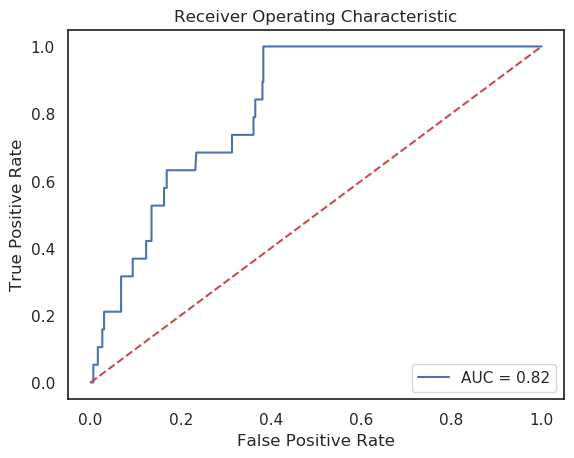

In [62]:
s3_input_test = "s3://{}/{}".format(read_bucket, test_data_key)
model = joblib.load('./tmp/model/xgboost-model')
test_auc = evaluate(s3_input_test, model)
print(" Test AUC for baseline model" ,round(test_auc,2))

# Step 6: Launch hyperparameter tuning jobs in script mode using SageMaker Hyperparameter tuning jobs

In [63]:
# SageMaker estimator

# Set static hyperparameters that will not be tuned
static_hyperparams = {  
                        "eval_metric" : "auc",
                        "objective": "binary:logistic",
                        "num_round": "100"
                      }

xgb_estimator = XGBoost(
                        entry_point="xgboost_train.py",
                        output_path=estimator_output_uri,
                        code_location=estimator_output_uri,
                        hyperparameters=static_hyperparams,
                        role=sagemaker_role,
                        instance_count=train_instance_count,
                        instance_type=train_instance_type,
                        framework_version="1.3-1",
                        base_job_name=training_job_name_prefix
                    )

# Setting ranges of hyperparameters to be tuned
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "subsample": ContinuousParameter(0.7, 0.95),
    "colsample_bytree": ContinuousParameter(0.7, 0.95),
    "max_depth": IntegerParameter(1, 8)
}

objective_metric_name = "validation:auc"

# Setting up tuner object
tuner_config_dict = {
                     "estimator" : xgb_estimator,
                     "max_jobs" : 5,
                     "max_parallel_jobs" : 2,
                     "objective_metric_name" : objective_metric_name,
                     "hyperparameter_ranges" : hyperparameter_ranges,
                     "base_tuning_job_name" : tuning_job_name_prefix,
                     "strategy" : "Random"
                    }
tuner = HyperparameterTuner(**tuner_config_dict)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m4.xlarge.


#### [Note 1]: Below cell ⬇️ will take about 7 mins to run as it tries to tune multiple parameters ( each dot indicates running state and ! indicates completion of the job)

#### [Note 2] You can head over to Sagemaker Console -> Hyperparameter tuning jobs to view the progress of the launched tuning jobs

In [64]:
# Setting the input channels for tuning job
s3_input_train = TrainingInput(s3_data="s3://{}/{}".format(read_bucket, train_data_key), content_type="csv", s3_data_type="S3Prefix")
s3_input_validation = (TrainingInput(s3_data="s3://{}/{}".format(read_bucket, validation_data_key), 
                                    content_type="csv", s3_data_type="S3Prefix")
                      )

tuner.fit(inputs={"train": s3_input_train, "validation": s3_input_validation}, include_cls_metadata=False)
tuner.wait()

INFO:sagemaker:Creating hyperparameter tuning job with name: xgbtune-dewanup-230403-1657


....................................................................!
!


### Analyzing Tuner results

In [65]:
# Summary of tuning results ordered in descending order of performance
df_tuner = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name).dataframe()
df_tuner = df_tuner[df_tuner["FinalObjectiveValue"]>-float('inf')].sort_values("FinalObjectiveValue", ascending=False)
df_tuner

,colsample_bytree,eta,max_depth,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,0.709006,0.208380,4.0,0.857820,xgbtune-dewanup-230403-1657-001-c4c161c5,Completed,0.77,2023-04-03 16:58:52+00:00,2023-04-03 17:00:39+00:00,107.0
3,0.788081,0.205627,7.0,0.864487,xgbtune-dewanup-230403-1657-002-3561c6be,Completed,0.76,2023-04-03 16:59:04+00:00,2023-04-03 17:00:47+00:00,103.0
0,0.946808,0.673981,3.0,0.836079,xgbtune-dewanup-230403-1657-005-975e8a54,Completed,0.75,2023-04-03 17:02:22+00:00,2023-04-03 17:02:55+00:00,33.0
1,0.860671,0.468213,5.0,0.771637,xgbtune-dewanup-230403-1657-004-fe120c66,Completed,0.73,2023-04-03 17:01:23+00:00,2023-04-03 17:01:56+00:00,33.0
2,0.718513,0.301855,4.0,0.801323,xgbtune-dewanup-230403-1657-003-03c2ee73,Completed,0.64,2023-04-03 17:02:29+00:00,2023-04-03 17:03:01+00:00,32.0


### UI to Check: 📺
    - Experiments -> Hyperparameter Tuning Job / SM Hyperparameter Training Console

# Step 7: Evaluate the Hyperparameter Tuner Model

In [66]:
best_train_job_name = tuner.best_training_job()
model_s3_uri = estimator_output_uri + '/' + best_train_job_name + '/output/model.tar.gz'

In [67]:
!mkdir -p ./tmp/hpo-model/
!aws s3 cp $model_s3_uri ./tmp/hpo-model/model.tar.gz
!tar -xvzf ./tmp/hpo-model/model.tar.gz -C ./tmp/hpo-model/

download: s3://sagemaker-us-east-1-539179515961/fraud-detect-demo-dewanup/training_jobs/xgbtune-dewanup-230403-1657-001-c4c161c5/output/model.tar.gz to tmp/hpo-model/model.tar.gz
xgboost-model


 Test AUC for baseline model 0.81


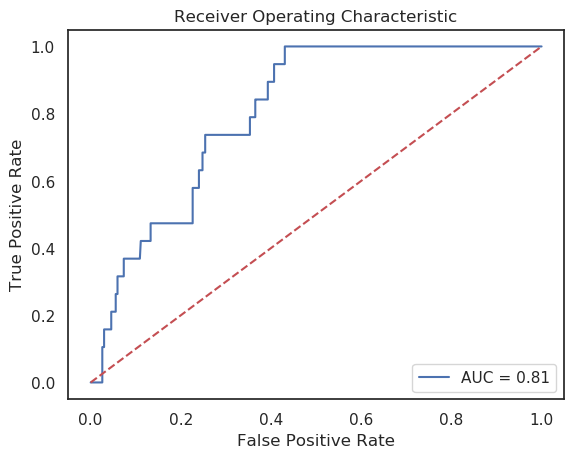

In [68]:
s3_input_test = "s3://{}/{}".format(read_bucket, test_data_key)
model = joblib.load('./tmp/hpo-model/xgboost-model')
test_auc = evaluate(s3_input_test, model)
print(" Test AUC for baseline model" ,round(test_auc,2))

# Step 8: Deploy the Model using SM Endpoints for further inference testing

In [69]:
tuner_job_info = sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)

model_matches = sagemaker_client.list_models(NameContains=xgb_model_name)["Models"]

if not model_matches:
    _ = sess.create_model_from_job(
            name=xgb_model_name,
            training_job_name=tuner_job_info['BestTrainingJob']["TrainingJobName"],
            role=sagemaker_role,
            image_uri=tuner_job_info['TrainingJobDefinition']["AlgorithmSpecification"]["TrainingImage"]
            )
else:

    print(f"Model {xgb_model_name} already exists.")

Model fraud-detect-xgb-model-dewanup already exists.


In [76]:
best_train_job_name = tuner.best_training_job()

model_path = estimator_output_uri + '/' + best_train_job_name + '/output/model.tar.gz'
training_image = retrieve(framework="xgboost", region=region, version="1.3-1")
create_model_config = {"model_data":model_path,
                       "role":sagemaker_role,
                       "image_uri":training_image,
                       "name":endpoint_name_prefix,
                       "predictor_cls":sagemaker.predictor.Predictor
                       }
# Create a SageMaker model
model = sagemaker.model.Model(**create_model_config)

# Deploy the best model and get access to a SageMaker Predictor
predictor = model.deploy(initial_instance_count=predictor_instance_count, 
                         instance_type=predictor_instance_type,
                         serializer=CSVSerializer(),
                         deserializer=CSVDeserializer())
print(f"\nModel deployed at endpoint : {model.endpoint_name}")


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: xgb-fraud-model-dev-dewanup
INFO:sagemaker:Creating endpoint-config with name xgb-fraud-model-dev-dewanup-2023-04-03-06-19-11-018
INFO:sagemaker:Creating endpoint with name xgb-fraud-model-dev-dewanup-2023-04-03-06-19-11-018


--------!
Model deployed at endpoint : xgb-fraud-model-dev-dewanup-2023-04-03-06-19-11-018


In [91]:
# Sample test data
test_df = pd.read_csv(test_data_uri)
payload = test_df.drop(["fraud"], axis=1).iloc[10].to_list()
print(f"Model prediction : {int(float(predictor.predict(payload)[0][0]))}, True label : {test_df['fraud'].iloc[10]}")

Model prediction : 0, True label : 0
